Разберемся с перцентилями и распределениями которые можно использовать в деревьях решений.

Исходная задача - как можно использовать величины заданные перцентилями, например оценка запасов заданная тремя значениями p10, p50, p90 при построении деревьев решений.

Общая схема - перцентили определяют некоторое непрерывное распределение описывающее неопределенность заданной величины. Если распределение фиксировать можно его приблизить дискретным распределением, которое в свою очередь может быть использовано при построении деревьев решений. 

Подход удобно проиллюстировать расчетами с использованием библиотеки scipy.stats. 

In [130]:
from scipy.stats import lognorm, norm
from scipy import stats
import scipy
import numpy as np
import matplotlib.pyplot as plt

Начнем с нормального распределения

Нормальное распределение - непрерывное распределение вероятностей с пиком в центре и симметричными боковыми сторонами, которое в одномерном случае задаётся функцией плотности вероятности, совпадающей с функцией Гаусса:

$$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

функция распределения

$$\Phi\left(\frac{x-\mu}{\sigma}\right) = \frac{1}{2}\left[1 + \operatorname{erf}\left( \frac{x-\mu}{\sigma\sqrt{2}}\right)\right]$$

Нормальное распределение определяется двуми параметрами - $\mu$ и $\sigma$. Параметр $\mu$ определяет среднее значение распределения, а параметр $\sigma$ - его дисперсию. 

В scipy.stats параметры распределения обозначаются как `loc` и `scale`, соответственно. Параметр `loc` задаёт среднее значение распределения, а параметр `scale` - его дисперсию.

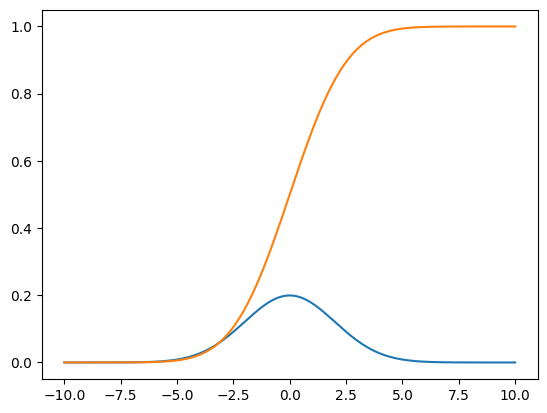

In [111]:
# Построим графики функции распределения и плотности распределения для нормального распределения
x = np.linspace(-10, 10, 1000)
ndist = norm(loc=-0, scale=2)

plt.plot(x, ndist.pdf(x))
plt.plot(x, ndist.cdf(x))

plt.show()


In [112]:
# проверим, что интеграл функции плотности распределения вероятности равен 1
print(np.trapezoid(pdf, x))
print(scipy.integrate.simpson(pdf, x=x))

0.9999994265727195
0.9999994266967668


In [113]:
# по известному распределению легко подсчитать перцентили
print(f'p10 = {ndist.ppf(0.1)}')
print(f'p50 = {ndist.ppf(0.5)}')
print(f'p90 = {ndist.ppf(0.9)}')

p10 = -2.5631031310892007
p50 = 0.0
p90 = 2.5631031310892007


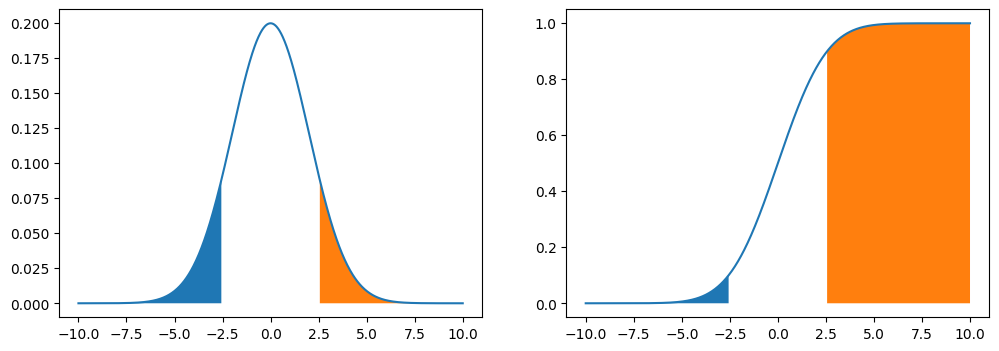

In [126]:
def plot_dist(ndist, p1=0.1, p2=0.9, xmin=-10, xmax=10, points=1000):
    """
    функция отрисовки распределения и его плотности с указанием перцентилей
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))


    x = np.linspace(xmin, xmax, points)
    x_p1 = np.linspace(xmin, ndist.ppf(p1), points)
    x_p2 = np.linspace(ndist.ppf(p2), xmax, points)

    ax1.plot(x, ndist.pdf(x))
    ax1.fill_between(x_p1, ndist.pdf(x_p1))
    ax1.fill_between(x_p2, ndist.pdf(x_p2))


    ax2.plot(x, ndist.cdf(x))
    ax2.fill_between(x_p1, ndist.cdf(x_p1))
    ax2.fill_between(x_p2, ndist.cdf(x_p2))

    plt.show()

ndist = norm(loc=-0, scale=2)
plot_dist(ndist)

Нормальное распределение задается двумя параметрами - $\mu$ и $\sigma$, где $\mu$ - математическое ожидание (среднее значение), а $\sigma$ - стандартное отклонение.

Для нормального распределения легко вычислить параметры распределения по двум перцентилям.

$$
\mu = \frac{x_2 - x_1}{\phi^{-1}(p_2) - \phi^{-1}(p_1)} 
$$
$$
\sigma = \frac{x_1\phi^{-1}(p_2) - x_2\phi^{-1}(p_1)}{\phi^{-1}(p_2) - \phi^{-1}(p_1)}
$$

здесь $\phi^{-1}$ - обратная функция к `сdf(x)`, которая принимает значение в диапазоне от 0 до 1 и возвращает значение в диапазоне от -inf до inf.

In [127]:
def norm_from_percentiles(x1, p1, x2, p2):
    """ 
    возвращает параметры нормального распределения, заданные двумя перцентилями и значением в диапазоне от 0 до 1
    
            P(X < p1) = x1
            P(X < p2) = x2
    """
    p1ppf = norm.ppf(p1)
    p2ppf = norm.ppf(p2)

    location = ((x1 * p2ppf) - (x2 * p1ppf)) / (p2ppf - p1ppf)
    scale = (x2 - x1) / (p2ppf - p1ppf)

    return norm(loc=location, scale=scale)

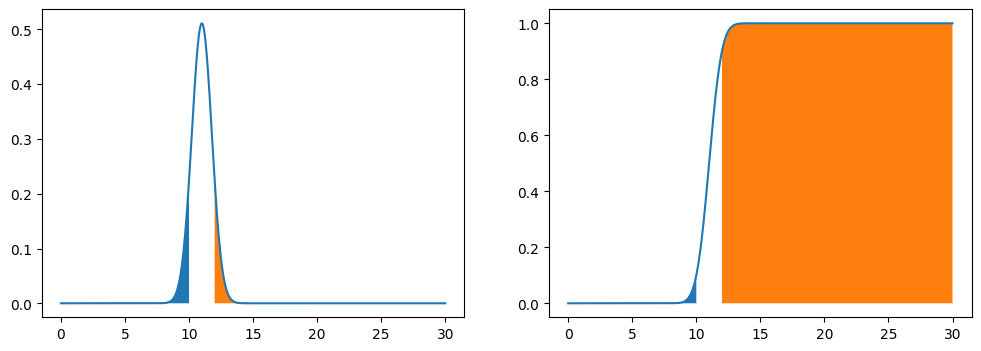

In [129]:
p_1 = 0.1
p_2 = 0.9
v_1 = 10
v_2 = 12

ndist2 = norm_from_percentiles(x1=v_1, p1=p_1, x2=v_2, p2=p_2) 

plot_dist(ndist2, xmin=0, xmax=30, p1=p_1, p2=p_2)

Для построение дискретного распределения на основе непрерывного можно задаться произвольными интервалами вероятностей от 0 до 1 и для каждого интервала рассчитать условное математическое ожидание величины в этом интервале.

значения интервалов вероятностей [0.1, 0.19999999999999998, 0.2, 0.19999999999999996, 0.20000000000000007, 0.09999999999999998]
0.10
0.20
0.20
0.20
0.20
0.10
значения искомой величины на каждом интервале [np.float64(7.229344297322037), np.float64(12.461353285624165), np.float64(16.00036273668453), np.float64(18.999637263315467), np.float64(22.53864671437585), np.float64(27.770655702677935)]
7.23
12.46
16.00
19.00
22.54
27.77


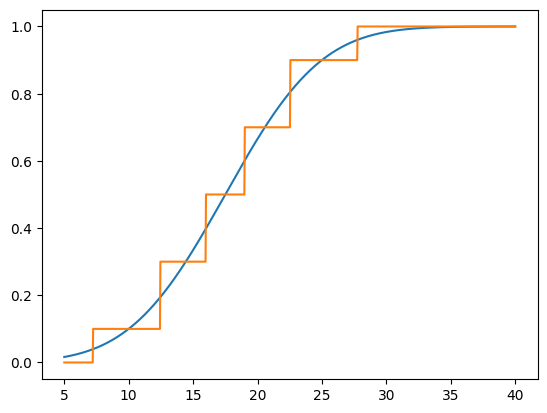

In [181]:
# Зададим исходное непрерывное нормальное распределение
p10 = 10
p90 = 25
ndist2 = norm_from_percentiles(p10, 0.1, p90, 0.9)

# Зададим список интервалов вероятностей от 0 до 1 для которых будет рассчитывать дискретное распределение
p_list = [0.1, 0.3, 0.5, 0.7, 0.9]

# Рассчитаем дискретное распределение по интервалам вероятностей
def discrete_dist(ndist, p_list):

    p_list = [0] + p_list + [1]
    x_list = []
    pm_list = []
    for i, val in enumerate(p_list):
        if i > 0:
            x_list.append(ndist2.expect(lb=ndist.ppf(p_list[i-1] ), 
                                        ub=ndist.ppf(p_list[i]),     
                                        conditional=True)
                        )
            pm_list.append(p_list[i] - p_list[i-1])

    ndist2_discrete = stats.rv_discrete(name='ndist2_discrete', values=(x_list, pm_list))
    return ndist2_discrete

ndist2_discrete = discrete_dist(ndist=ndist2, p_list=p_list)    
# нарисуем результаты расчетов в виде графиков функции распределения

x = np.linspace(5, 40, 1000)
plt.plot(x, ndist2.cdf(x))
plt.plot(x, ndist2_discrete.cdf(x))

print(f'значения интервалов вероятностей {pm_list}')
for pm in pm_list:
    print(f'{pm:.2f}')
print(f'значения искомой величины на каждом интервале {x_list}')
for x in x_list:
    print(f'{x:.2f}')


Использование нормального распределения не всегда удобно в реальных задачах, так как нормальное распределение может принимать отрицательные значения.

Можно использовать, например, логнормальное распределение. 

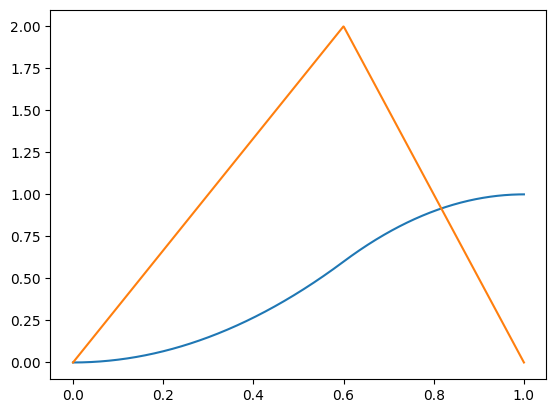

In [108]:
d = stats.triang(c=0.6)

x = np.linspace(0, 1, 1000)
plt.plot(x, d.cdf(x))
plt.plot(x, d.pdf(x))

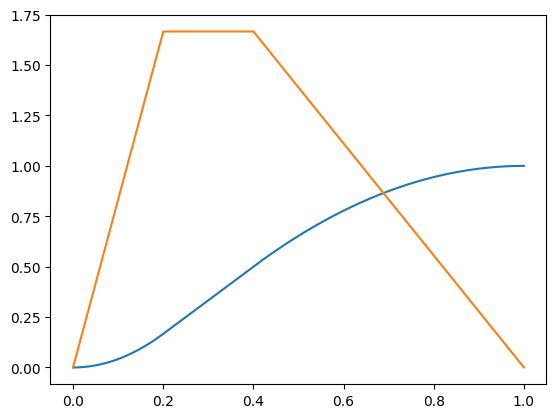

In [109]:
d = stats.trapezoid(c=0.2, d=0.4)

x = np.linspace(0, 1, 1000)
plt.plot(x, d.cdf(x))
plt.plot(x, d.pdf(x))